In [11]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import mlflow
import mlflow.sklearn

In [2]:
df=pd.read_csv("twitter_dataset.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,text
0,5.703061e+17,neutral,@VirginAmerica What @dhepburn said.
1,5.703011e+17,positive,@VirginAmerica plus you've added commercials t...
2,5.703011e+17,neutral,@VirginAmerica I didn't today... Must mean I n...
3,5.703010e+17,negative,@VirginAmerica it's really aggressive to blast...
4,5.703008e+17,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
mydf=df.copy()

In [5]:
mydf=mydf.drop('tweet_id',axis=1)

In [6]:
mydf['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [8]:
count_sentiment=mydf['airline_sentiment'].value_counts().reset_index()

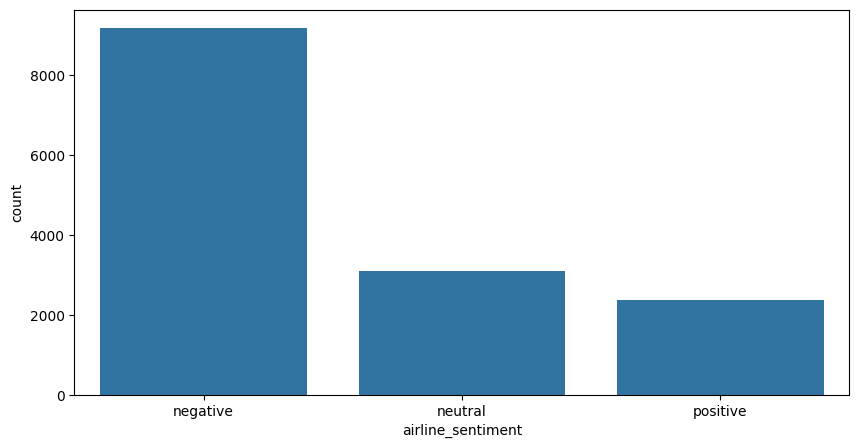

In [10]:
plt.figure(figsize=(10,5))
sn.barplot(x='airline_sentiment',y='count',data=count_sentiment)
plt.show()

### Encode the target feature

In [12]:
le=LabelEncoder()
mydf['airline_sentiment_encoded']=le.fit_transform(df['airline_sentiment'])

In [13]:
mydf['airline_sentiment_encoded'].value_counts()

airline_sentiment_encoded
0    9178
1    3099
2    2363
Name: count, dtype: int64

# Text preprossing

In [14]:
mydf['text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

# Download NLTK stopwords and punkt if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    """
    Preprocesses the text by normalizing, removing special characters, punctuation,
    stop words, and HTML tags.
    
    Parameters:
    - text (str): The input text to preprocess.
    
    Returns:
    - str: The preprocessed text.
    """
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 3. Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # 4. Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 5. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenize the text
    tokens = word_tokenize(text)

    # 7. Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 8. Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Example usage
# sample_text = """
#     Check out the latest updates at https://example.com. <b>The cat in the hat</b> sat on the mat! 
#     It was a sunny day in New York.
# """
# preprocessed = preprocess_text(sample_text)
# print(preprocessed)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\acer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
mydf['text_cleaned']=mydf['text'].apply(preprocess_text)

C:\Users\acer\AppData\Local\Temp\ipykernel_14512\2056037865.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


1. Feature Extraction

Convert the cleaned text data into numerical features that can be used by machine learning algorithms. Common methods include:
TF-IDF Vectorization: Measures the importance of words in the documents relative to the corpus.
Word Embeddings: Use pre-trained embeddings like Word2Vec, GloVe, or contextual embeddings like BERT if needed.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(mydf['text_cleaned'])

# View the shape of the transformed data
print(X.shape)


(14640, 15323)


Splitting the Data

Divide your data into training and testing sets to evaluate the performance of your model.

In [20]:
from sklearn.model_selection import train_test_split

# Features and labels
y = mydf['airline_sentiment_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training

Choose and train a model for sentiment classification. You can start with simple models like Naive Bayes or move to more complex ones like SVM, Random Forest, or even neural networks.

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.6977
              precision    recall  f1-score   support

    negative       0.69      0.99      0.81      1889
     neutral       0.74      0.14      0.24       580
    positive       0.92      0.19      0.31       459

    accuracy                           0.70      2928
   macro avg       0.78      0.44      0.45      2928
weighted avg       0.74      0.70      0.62      2928



Model Monitoring with MLflow

Step 1: Log the Model

In [31]:
import mlflow
import mlflow.sklearn

# Set the tracking URI to use an HTTP server (e.g., local MLflow server)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment(experiment_name="nlp experiment")

# Start MLflow run
with mlflow.start_run(run_name="NaiveBayes") as run:
    # mlflow.run(run_name='NaiveBayes')
    # Log parameters
    mlflow.log_param("model_type", "Naive Bayes")
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    
    # Log model
    mlflow.sklearn.log_model(model, "model")

    # Print run details
    print(f"Run ID: {run.info.run_id}")

model_uri = f"runs:/{run.info.run_id}/model"


2024/09/17 22:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 22:56:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run NaiveBayes at: http://127.0.0.1:5000/#/experiments/605120961956748137/runs/13ee69e0241745cb8148a8647d03f1ad.
2024/09/17 22:56:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/605120961956748137.


Run ID: 13ee69e0241745cb8148a8647d03f1ad


Step 2: Register the Model

In [32]:
import mlflow

# Define the model name
model_name = "NaiveBayesModel"

# Register the model
result = mlflow.register_model(model_uri, model_name)
print(f"Model registered with name '{model_name}' and version {result.version}")


Successfully registered model 'NaiveBayesModel'.
2024/09/17 22:57:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NaiveBayesModel, version 1


Model registered with name 'NaiveBayesModel' and version 1


Created version '1' of model 'NaiveBayesModel'.


Transition the Model to Staging

In [33]:
from mlflow.tracking import MlflowClient

# Initialize MLflow client
client = MlflowClient()

# Get the latest version of the registered model
model_versions = client.get_latest_versions(model_name)
latest_version = model_versions[0].version

# Transition the model to Staging
client.transition_model_version_stage(
    name=model_name,
    version=latest_version,
    stage="Staging"
)

print(f"Model version {latest_version} has been moved to Staging.")


Model version 1 has been moved to Staging.


C:\Users\acer\AppData\Local\Temp\ipykernel_14512\1198464772.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  model_versions = client.get_latest_versions(model_name)
C:\Users\acer\AppData\Local\Temp\ipykernel_14512\1198464772.py:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


Model Testing in Staging

1.Before moving the model to "Production", you should thoroughly test it in the "Staging" environment to ensure it performs well with real-world data. This includes:

    Performance Evaluation: Check if the model's performance metrics (e.g., accuracy, precision, recall) meet your requirements.
    Validation: Validate the model with a separate validation set to ensure it generalizes well.
    User Acceptance Testing: Allow stakeholders or end-users to test the model and provide feedback.

2.Prepare for Production Deployment

If the model passes all tests and is ready for deployment, you'll need to transition it to the "Production" stage. This involves:
Transition Model to Production

Use the MlflowClient to transition the model to the "Production" stage.

### Evaluate Model Performance

In [39]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Ensure to start and end runs properly
def log_metrics(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print metrics and classification report
    print(f"Model Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

# Example usage
log_metrics(model, X_test, y_test)


Model Accuracy: 0.6977
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.99      0.81      1889
           1       0.74      0.14      0.24       580
           2       0.92      0.19      0.31       459

    accuracy                           0.70      2928
   macro avg       0.78      0.44      0.45      2928
weighted avg       0.74      0.70      0.62      2928



Promote the Model to Production

In [42]:
# Transition model version to production
client.transition_model_version_stage(
    name='NaiveBayesModel',
    version=1,
    stage="Production"
)
print(f"Model version {model_versions} moved to Production")


Model version [<ModelVersion: aliases=[], creation_timestamp=1726594020843, current_stage='None', description='', last_updated_timestamp=1726594020843, name='NaiveBayesModel', run_id='13ee69e0241745cb8148a8647d03f1ad', run_link='', source='mlflow-artifacts:/605120961956748137/13ee69e0241745cb8148a8647d03f1ad/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>] moved to Production


C:\Users\acer\AppData\Local\Temp\ipykernel_14512\2756827811.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [56]:
import mlflow

# Set the tracking URI to use an HTTP server (e.g., local MLflow server)
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Replace with your MLflow server URL